# **Stat Tests and Multiple Linear Regression: The equation relashioship between Chevron stock price x Crude Oil and Natural Gas prices**




# Storyteling
When Louis Bachelier presented option pricing model counting on negative asset prices (The Theory of Speculation, 1900), he also offered the basis to Matematical Finance and Eficcient Market Hypotesis.

But curiously, we adopted the Black & Scholes Model (The Pricing of Options and Corporate Liabilities, 1973) which estimates the european style option price with a unique price given it´s risk and expected return. This model doesn´t allow a negative price.

Since oil had his first time negative price in history in 20/4/2020 (-37,63 USD) and natural gas price has suffering with Russia-Ukraine war, we thought about modeling the Multiple Linear Regression equation from the relashionship between the threesome: Chevron Stock Price (one of the biggest oil and natural gas companies); Crude Oil Price and Natural Gas Price.

We made some statistical tests like Shapeness (histograms, dist and hug plots) and explored Skewness and Kurtosis tests, ZScore and then.

As a conclusion, we should reject null hipotesis and indicate that there´s a correlation between these features.

There is a caveat: Correlation would be higher if we removed natural gas feature price from our Multi Linear Reg model, since it´s slope is negative. That makes sense: multinational energy companies (and european, of course) are looking for alternatives to reduce dependency of Russian natural gas.  




# 1) Import Libraries

In [2]:
!pip install yfinance -q
import yfinance as yf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px                               # I´d rather plotly iterativity than seaborn and matplotlib
import plotly.graph_objects as go
!pip install statsmodels                                  # For some statistical metrics
import statsmodels.api as sm
import math
import seaborn as sns
import plotly.figure_factory as ff                        # Figure factory creates specific types of plots
from plotly.figure_factory import create_distplot

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score  # for some statistical metrics

from scipy import stats
from scipy.stats import kurtosis, skew
import statistics

%matplotlib inline

# 2) Webscrapp e Cleaning Data


In [3]:
# Webscrapping via Yahoo finance

# Commotities list: https://finance.yahoo.com/commodities/

price_chevron = (yf.download('CVX')[['Adj Close']])         # Chevron stock price
price_crudeoil = (yf.download('CL=F')[['Adj Close']])       # Crude oil price
price_natgas = (yf.download('NG=F')[['Adj Close']])         # Natural gas price

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [4]:
# Rename columns
price_chevron.rename(columns={'Adj Close': 'chevron'}, inplace=True)
price_crudeoil.rename(columns={'Adj Close': 'crude_oil'}, inplace=True)
price_natgas.rename(columns={'Adj Close': 'nat_gas'}, inplace=True)

In [5]:
# Concatenate data to the same dataframe
price = round(pd.concat([price_chevron, price_crudeoil, price_natgas], axis=1), 2)
price = price.dropna()

In [6]:
price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5822 entries, 2000-08-30 to 2023-11-10
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   chevron    5822 non-null   float64
 1   crude_oil  5822 non-null   float64
 2   nat_gas    5822 non-null   float64
dtypes: float64(3)
memory usage: 181.9 KB


In [7]:
price.tail()

,chevron,crude_oil,nat_gas
Date,,,
2023-11-06,147.00,80.82,3.26
2023-11-07,144.41,77.37,3.14
2023-11-08,142.40,75.33,3.11
2023-11-09,141.94,75.74,3.04
2023-11-10,142.80,77.26,3.04


# 3) Exploratory Data Analysis and Plots

In [8]:
# Some descriptive statistics
price.describe()

,chevron,crude_oil,nat_gas
count,5822.000000,5822.000000,5822.000000
mean,64.584425,64.162130,4.525541
std,37.973038,25.524149,2.248089
min,14.260000,-37.630000,1.480000
25%,32.540000,44.752500,2.830000
50%,63.610000,61.935000,3.880000
75%,84.235000,83.910000,5.710000
max,182.580000,145.290000,15.380000


In [9]:
# Watch out for the first negative crude oil price in history
(price[price['crude_oil'] < 0])

,chevron,crude_oil,nat_gas
Date,,,
2020-04-20,71.35,-37.63,1.92


In [10]:
# Chevron price - Interactive Boxplot

df = px.data.tips()
fig = px.box(df, y=price['chevron'])
fig.update_layout(
    title="Chevron Stock Price in US$ - Boxplot",
    yaxis_title="Chevron Stock Price")

fig.show()

In [11]:
# Crude oil price - Interactive Boxplot

# Here you can check the negative oil price. This was an interesting event because of the firt time crude oil price
# traded down to a negative one. Check more on: http://www.jpmcc-gcard.com/digest-uploads/2020-winter/issue-pages/Page%2060_70%20GCARD%20Winter%202020%20Sterijevski.pdf
# Check https://plotly.com/chart-studio-help/what-is-a-box-plot/   to better understand the calculus of the descriptive
# statistics


df = px.data.tips()
fig = px.box(df, y=price['crude_oil'])
fig.update_layout(
    title="Crude oil price in US$ - Boxplot",
    yaxis_title="Crude oil price")

fig.show()

In [12]:
# Natural gas price - Interactive Boxplot

# Look at the amount of data between upper fence and max. Compare to the Q1. The actual price is on it now.
# Certainly it´s because of the Russia-Ukraine gas disputes.

df = px.data.tips()
fig = px.box(df, y=price['nat_gas'])
fig.update_layout(
    title="Natural Gas price in US$ - Boxplot",
    yaxis_title="Natural gas price")

fig.show()

# 4) Statistical Tests

Here we intent to verify the statistical relashionship between the two features and the response.

##4.1) Shape (histogram, Dist and Rug plots) and conclusion

In [13]:
# Drop outlier as a potencial problem in a linear regression

price.drop(['2020-04-20'], inplace = True)

In [14]:
# Chevron price as function of crude oil price (outlier excluded)

df = px.data.tips()
fig = px.scatter(df, y=price['chevron'], x=price['crude_oil'],
                 width= 600, height = 600)

fig.update_layout(
                 title =' Chevron price as function of crude oil price (outlier excluded)',
                 yaxis_title="Chevron price",
                 xaxis_title="Crude oil price")

fig.show()

In [15]:
# Chevron price as function of natural gas price (outlier excluded)

# Watch out this coment at Chevron´s 2022 Annual Report: "Natural gas demand declined slightly last year, as
# higher prices related to supply disruptions resulting from the Russia-Ukraine conflict prompted fuel substitution
# and demand destruction, especially in Europe"

# Source: https://www.chevron.com/-/media/chevron/annual-report/2022/documents/2022-Annual-Report.pdf

df = px.data.tips()
fig = px.scatter(df, y=price['chevron'], x=price['nat_gas'],
                 width= 600, height = 600)

fig.update_layout(
                 title =' Chevron price as a function of natural gas price (outlier excluded)',
                 yaxis_title="Chevron price",
                 xaxis_title="Natural gas price")

fig.show()

In [16]:
price.tail()

,chevron,crude_oil,nat_gas
Date,,,
2023-11-06,147.00,80.82,3.26
2023-11-07,144.41,77.37,3.14
2023-11-08,142.40,75.33,3.11
2023-11-09,141.94,75.74,3.04
2023-11-10,142.80,77.26,3.04


array([[<Axes: title={'center': 'chevron'}>,
        <Axes: title={'center': 'crude_oil'}>],
       [<Axes: title={'center': 'nat_gas'}>, <Axes: >]], dtype=object)

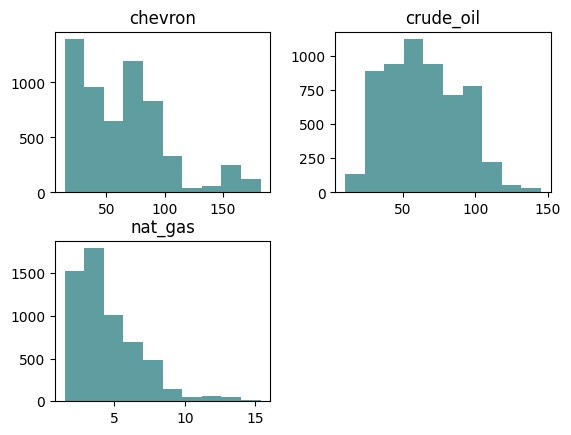

In [17]:
price.hist(grid=False, color = 'cadetblue')

In [18]:
# Check data

(price[price['crude_oil'] < 0])

,chevron,crude_oil,nat_gas
Date,,,


In [19]:
# Chevron Historical Price - Histogram distribuition

df = px.data.tips()
fig = px.histogram(df, x = price['chevron'],
                   title = 'Chevron histogram')
fig.update_layout(xaxis_title = 'Chevron Price')
fig.show()

In [20]:
# Crude Oil Historical Price - Histogram distribuition


df = px.data.tips()
fig = px.histogram(df, x = price['crude_oil'],
                   title = 'Crude Oil histogram')
fig.update_layout(xaxis_title = 'Crude Oil Price')
fig.show()

In [21]:
# Natural Gas Historical Price - Histogram distribuition


df = px.data.tips()
fig = px.histogram(df, x = price['nat_gas'],
                   title = 'Natural Gas histogram')
fig.update_layout(xaxis_title = 'Natural gas Price')
fig.show()

In [22]:
# Distplot and normal distribuition - Chevron price x Crude Oil price

# A distplot tells us about the variation of the data distribuition (in terms of bins).

x1 = price['chevron']
x2 = price['crude_oil']


group_labels = ['Chevron', 'Crude_oil']

colors = ['blue', 'black']

# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot([x1, x2], group_labels, bin_size=.5,
                         curve_type='normal', # override default 'kde'
                         colors=colors)

# Add title
fig.update_layout(title_text='Distplot with Normal Distribution - Chevron price x Crude Oil price')
fig.show()

In [23]:
# Distplot and normal distribuition - Chevron price x Natural gas price

# A distplot tells us about the variation of the data distribuition (in terms of bins).

x1 = price['chevron']
x3 = price['nat_gas']


group_labels = ['Chevron', 'Natural_Gas']

colors = ['blue', 'gray']

# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot([x1, x3], group_labels, bin_size=.5,
                         curve_type='normal', # override default 'kde'
                         colors=colors)

# Add title
fig.update_layout(title_text='Distplot with Normal Distribution - Chevron price x Crude Oil price')
fig.show()

In [24]:
# Distplot and normal distribuition - Crude Oil price x Natural gas price

# A distplot tells us about the variation of the data distribuition (in terms of bins).

x2 = price['crude_oil']
x3 = price['nat_gas']


group_labels = ['Crude_Oil', 'Natural_Gas']

colors = ['black', 'gray']

# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot([x2, x3], group_labels, bin_size=.5,
                         curve_type='normal', # override default 'kde'
                         colors=colors)

# Add title
fig.update_layout(title_text='Distplot with Normal Distribution - Chevron price x Crude Oil price')
fig.show()

In [25]:
# Rug Plot (= Distplot in terms of bins) - Chevron x Crude Oil

# A rug plot is a distplot in terms of bins. We have more data from chevron price than crude oil price.
# Neverthless, we can see some trends: Sometimes it looks like chevron price antecipates crude oil price. Watch out
# the curves.
# Going further still: Between these two tendencies of antecipation, there is a miscorrelation. As long as crude oil
# price goes up, chevron price goes down.

x1 = price['chevron']
x2 = price['crude_oil']


hist_data = [x1, x2]

group_labels = ['Chevron','Crude Oil']
colors = ['#333F44','#37AA9C']

# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot(hist_data, group_labels, show_hist=False, colors=colors)

# Add title
fig.update_layout(title_text='Rug Plot and Curve - Chevron x Crude Oil')
fig.show()

In [26]:
# Rug Plot (= Distplot in terms of bins) - Nat Gas

x3 = price['nat_gas']

hist_data = [x3]

group_labels = ['Natural Gas']
colors = ['#94F3E4']

# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot(hist_data, group_labels, show_hist=False, colors=colors)

# Add title
fig.update_layout(title_text='Rug Plot and Curve - Natural Gas')
fig.show()

**Conclusions on Chevron Shape**

Chevron stock price is a multimodal distribuition, wich means it´s probability distribuition has 2 or more modes


Since the Skweness value return is positive, the curve is skewed to the right.

Remember: There is a noted slight evidence of positive skweness in a stock individual return (Return Distribuitions
in Finance - John Knight, page 23)

Besides, there are 3 ways to analise Skewness in a normal distribuition:
        
         1) Perfectly Normal:     μ = x͂ = Mo       (wich is: mean = median = mode)
         2) Skewed to the left:   μ < x͂ < Mo       (wich is: mean <  median < mode)
         3) Skewed to the right: Mo < x͂ < μ        (wich is: median < mode < mean)

It´s best to have a skewed to the left stock return since the mode (the most frequent values) are more frequent.

However, many trading strategies are based on skewed to the left distribuitions.

**Conclusions on Crude oil Shape**

Crude oil price is a multimodal distribuition, wich means it´s probability distribuition has 2 or more modes. But its peak is larger when you compare with Chevron stock price.

Even if crude oil price is smaller than chevron´s price (but curiously the mean is the same), it´s 3 peaks are bigger than Chevron stock price when you plot in combination.

That means, maybe it´s a good idea to make a trading strategy with crude oil instead of chevron stock price

**Conclusions on Natural Gas Shape**

Natural Gas price is a unimodal distribuition, wich means it´s probability distribuition has only 1 mode (single peak).



## 4.2) Pearson Skewness, Adjusted Fisher-Pearson Skewness, SkewTest, ZScore, Kurtosis and Kurtosis Test

### 4.2.1) Chevron

In [27]:
# 4.2.1.1) Pearson Skewness - Chevron
# Source: Munro´s, Statistical Methods for healt care research - Plinchta & Kelvin, pag 48

# This coef falls between -1 and 1 standard deviation units.
# Hildebrand (1986) states that skewness values above 0.2 or below −0.2 indicate severe skewness
# As you can see, it´s not a severe skewness.

chevron_pearson_skew = (price['chevron'].mean() - price['chevron'].median()) / price['chevron'].std()
chevron_pearson_skew

0.025891542926526716

In [28]:
# 4.2.1.2) Adjusted Fisher-Pearson standardized moment coefficient of Skewness - Chevron
# Source: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skew.html


# This is an adjustment for sample size. The adjustment approaches 1 as N gets large.
# Source: https://www.itl.nist.gov/div898/handbook/eda/section3/eda35b.htm
chevron_fispearson_skew = skew(price['chevron'])
chevron_fispearson_skew

0.8873298754317899

In [29]:
# 4.2.1.3) Skew test

# This tests the null hypothesis that the skewness of the population that the sample was drawn from is the same as
# that of a corresponding normal distribution. In other words, null hipotesis claims that distribuition is not skewed.


# The skewed null hipotesis test claims that null hipotesis doesn´t follow a normal distribuition (i.e., follows a
# skewed dist).

# Based on it´s probability value:
#       If pvalue > 5%, there´s some evidence you should accept null hipotesis (i.e., chevron price follows a
# normal dist, is not skewed)
#       If pvalue < 5%, there´s some evidence you should reject null hipotesis (i.e., chevron price doen´t follows a
# a normal dist, is skewed)

# As you see, pvalue is highly bellow 5% (and negative). That indicates we have to reject null hipotesis that
# chevron price follows a normal distribuition (i.e. chevron price follows a skewed dist).
# Besides, a pvalue less than -1 indicates a highly skewed distribuition.

# Further more, "statistic" indicates a z score for this test. Since we are talking about large data and Z score ranges
# between -1,96 and 1,96 SD from the mean, this value indicates a high evidence of a non normality (skewness)

# Source: https://community.gooddata.com/metrics-and-maql-kb-articles-43/normality-testing-skewness-and-kurtosis-241
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skewtest.html

chevron_skewtest = stats.skewtest(price['chevron'])
chevron_skewtest

SkewtestResult(statistic=23.982527841480334, pvalue=4.231844359304061e-127)

In [30]:
# # 4.2.1.4) Z Score - Chevron
# A Z score between -1,96 and 1,96 SD from the mean scores in a normal distribuition ( isto é: bellow 1,96 or above
# 1,96 is significant at 5%, since the generally accepted confidence interval is 95%)

# As you can see, our value is bigger than -1,96. this indicates the distribution is not signifincantly skewed.


chevron_zscore = statistics.NormalDist(price['chevron'].mean(), price['chevron'].std()).zscore(5)
chevron_zscore

-1.5689633918937596

In [31]:
# 4.2.1.5) Kurtosis - Chevron (Fisher definition)
# This statistic measures whether the bell shape is too flat or too peaked (indicates whether a distribution has the
# right bell shape for a normal curve). Excess kurtosis describes non-normality of the probability distribution
# in the sense of heavier tails as well as a more accentuated density function about the mode relative to the
# normal distribution

# If you look at scipy stats doc bellow, you´ll see Fisher kurtosys relies on normal distribuition to the excess of
# skewness (greater than 3).

# It indicates a Leptokurtotic kurtosis, or a positive kurtosis larger than of a normal distribution. It indicates
# chances of rare events on returns (positive or negative). Look at Black Swans events



# Source: Munroâs, Statistical Methods for healt care research - Plinchta & Kelvin, pag 48
# Source: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kurtosis.html
# Source: Probability and Statistics for Finance - Fabozzi, chapter 13

chevron_kurt = kurtosis(price['chevron'], fisher = True)
chevron_kurt

0.5762098742682764

In [32]:
# 4.2.1.6) Kurtosis test

# This function tests the null hypothesis that the kurtosis of the population from which the sample was drawn is
# that of the normal distribution. In other words, the null hipotesis claims that distribuition is not "tailed".
# Kurtosis tells us the height and sharpness of the central peak distribuition.

# Based on it´s probability value:
#       If pvalue > 5%, there´s some evidence you should accept null hipotesis (i.e., chevron price doesn´t follows
# a tailed curve format)
#       If pvalue < 5%, there´s some evidence you should reject null hipotesis (i.e., chevron price follows
# a tailed curve format)

# As you see, pvalue is highly bellow 5%. That indicates we have to reject null hipotesis that chevron price
# follows a format of a bell curve (i.e. chevron price is not a standardized dist bell curve. There is high kurtosis).

# Further more, "statistic" indicates a z score for this test. Since we are talking about large data and Z score ranges
# between -1,96 and 1,96 SD from the mean, this value indicates a high evidence of a non normality (bell curve)

chevron_kurtest = stats.kurtosistest(price['chevron'])
chevron_kurtest

KurtosistestResult(statistic=7.096106604668067, pvalue=1.2832051015609962e-12)

### 4.2.2) Crude Oil

In [33]:
# 4.2.2.1) Pearson Skewness - Crude Oil

# Source: Munroâs, Statistical Methods for healt care research - Plinchta & Kelvin, pag 48

# This coef falls between -1 and 1 standard deviation units.
# Hildebrand (1986) states that skewness values above 0.2 or below −0.2 indicate severe skewness

# It´s coef is bigger than Chevron price (more skewed than), but it´s not severe
crude_pearson_skew = (price['crude_oil'].mean() - price['crude_oil'].median()) / price['crude_oil'].std()
crude_pearson_skew

0.08785760955144073

In [34]:
# 4.2.2.2) Adjusted Fisher-Pearson standardized moment coefficient of Skewness - Crude oil
# Source: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skew.html


# This is an adjustment for sample size. The adjustment approaches 1 as N gets large.
# Source: https://www.itl.nist.gov/div898/handbook/eda/section3/eda35b.htm
crude_fispearson_skew = skew(price['crude_oil'])
crude_fispearson_skew

0.2543477510869736

In [35]:
# 4.2.2.3) Skew test

# This tests the null hypothesis that the skewness of the population that the sample was drawn from is the same as
# that of a corresponding normal distribution. In other words, null hipotesis claims that distribuition is not skewed.


# The skewed null hipotesis test claims that null hipotesis doesn´t follow a normal distribuition (i.e., follows a
# skewed dist).

# Based on it´s probability value:
#       If pvalue > 5%, there´s some evidence you should accept null hipotesis (i.e., oil price follows a
# normal dist, is not skewed)
#       If pvalue < 5%, there´s some evidence you should reject null hipotesis (i.e., oil price doen´t follows a
# a normal dist, is skewed)

# As you see, pvalue is highly bellow 5% (and negative). That indicates we have to reject null hipotesis that
# chevron price follows a normal distribuition (i.e. chevron price follows a skewed dist).
# Besides, a pvalue less than -1 indicates a highly skewed distribuition.

# Further more, "statistic" indicates a z score for this test. Since we are talking about large data and Z score ranges
# between -1,96 and 1,96 SD from the mean, this value indicates a high evidence of a non normality (skewness)

# Source: https://community.gooddata.com/metrics-and-maql-kb-articles-43/normality-testing-skewness-and-kurtosis-241
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skewtest.html

crude_skewtest = stats.skewtest(price['crude_oil'])
crude_skewtest

SkewtestResult(statistic=7.809931902078317, pvalue=5.7218892659005554e-15)

In [36]:
# 4.2.2.4) Z Score - Crude Oil
# A Z score between -1,96 and 1,96 SD from the mean scores in a normal distribuition ( isto é: bellow 1,96 or above
# 1,96 is significant at 5%, since the generally accepted confidence interval is 95%)

# As you can see, our value is smaller than -1,96. This indicates a significant skew of the distribution.


crude_zscore = statistics.NormalDist(price['crude_oil'].mean(), price['crude_oil'].std()).zscore(5)
crude_zscore

-2.3215486833361667

In [37]:
# 4.2.2.5) Kurtosis - Crude Oil (Fisher definition)
# This statistic measures whether the bell shape is too flat or too peaked (indicates whether a distribution has the
# right bell shape for a normal curve). Excess kurtosis describes non-normality of the probability distribution
# in the sense of heavier tails as well as a more accentuated density function about the mode relative to the
# normal distribution

# If you look at scipy stats doc bellow, you´ll see Fisher kurtosys relies on normal distribuition to the excess of
# skewness (greater than 3).

# It indicates a Platykurtic kurtosis, or a negative kurtosis than that of a normal distribution. It indicates fewer
# chances of rare events on returns.



# Source: Munroâs, Statistical Methods for healt care research - Plinchta & Kelvin, pag 48
# Source: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kurtosis.html
# Source: Probability and Statistics for Finance - Fabozzi, chapter 13

crude_kurt = kurtosis(price['crude_oil'], fisher = True)
crude_kurt

-0.7012864112701047

In [38]:
# 4.2.2.6) Kurtosis test

# This function tests the null hypothesis that the kurtosis of the population from which the sample was drawn is
# that of the normal distribution. In other words, the null hipotesis claims that distribuition is not "tailed".
# Kurtosis tells us the height and sharpness of the central peak distribuition.

# Based on it´s probability value:
#       If pvalue > 5%, there´s some evidence you should accept null hipotesis (i.e., chevron price doesn´t follows
# a tailed curve format)
#       If pvalue < 5%, there´s some evidence you should reject null hipotesis (i.e., chevron price follows
# a tailed curve format)

# As you see, pvalue is highly bellow 5%. That indicates we have to reject null hipotesis that chevron price
# follows a format of a bell curve (i.e. chevron price is not a standardized dist bell curve. There is high kurtosis).

# Further more, "statistic" indicates a z score for this test. Since we are talking about large data and Z score ranges
# between -1,96 and 1,96 SD from the mean, this value indicates a high evidence of a non normality (bell curve)

crude_kurtest = stats.kurtosistest(price['crude_oil'])
crude_kurtest

KurtosistestResult(statistic=-17.53209592914657, pvalue=8.150878066311498e-69)

### 4.2.3) Natural Gas

In [39]:
# 4.2.3.1) Pearson Skewness - Natural Gas

# Source: Munroâs, Statistical Methods for healt care research - Plinchta & Kelvin, pag 48

# This coef falls between -1 and 1 standard deviation units.
# Hildebrand (1986) states that skewness values above 0.2 or below −0.2 indicate severe skewness

# It´s coef is bigger than Chevron and Oil price and exceed normality (severity ranges between -0,2 and 0,2).

# So, it indicates severe skewness

gas_pearson_skew = (price['nat_gas'].mean() - price['nat_gas'].median()) / price['nat_gas'].std()
gas_pearson_skew

0.28735862134627865

In [40]:
# 4.2.3.2) Adjusted Fisher-Pearson standardized moment coefficient of Skewness - Natural Gas
# Source: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skew.html


# This is an adjustment for sample size. The adjustment approaches 1 as N gets large.
# Source: https://www.itl.nist.gov/div898/handbook/eda/section3/eda35b.htm
gas_fispearson_skew = skew(price['nat_gas'])
gas_fispearson_skew

1.4423867301617694

In [41]:
# 4.2.3.3) Skew test

# This tests the null hypothesis that the skewness of the population that the sample was drawn from is the same as
# that of a corresponding normal distribution. In other words, null hipotesis claims that distribuition is not skewed.


# The skewed null hipotesis test claims that null hipotesis doesn´t follow a normal distribuition (i.e., follows a
# skewed dist).

# Based on it´s probability value:
#       If pvalue > 5%, there´s some evidence you should accept null hipotesis (i.e., nat gas follows a
# normal dist, is not skewed)
#       If pvalue < 5%, there´s some evidence you should reject null hipotesis (i.e., nat gas doen´t follows a
# a normal dist, is skewed)

# As you see, pvalue is highly bellow 5% (and negative). That indicates we have to reject null hipotesis that
# nat gas price follows a normal distribuition (i.e. nat gas price follows a skewed dist).
# Besides, a pvalue less than -1 indicates a highly skewed distribuition.

# Further more, "statistic" indicates a z score for this test. Since we are talking about large data and Z score ranges
# between -1,96 and 1,96 SD from the mean, this value indicates a high evidence of a non normality (skewness)

# Source: https://community.gooddata.com/metrics-and-maql-kb-articles-43/normality-testing-skewness-and-kurtosis-241
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skewtest.html

gas_skewtest = stats.skewtest(price['nat_gas'])
gas_skewtest

SkewtestResult(statistic=33.99452103605951, pvalue=2.6843647477488994e-253)

In [42]:
# # 4.2.3.4) Z Score - Natural Gas
# A Z score between -1,96 and 1,96 SD from the mean scores in a normal distribuition ( i.é. : bellow 1,96 or above
# 1,96 is significant at 5%, since the generally accepted confidence interval is 95%)

# As you can see, differently from skewtest above, our value indicates that nat gas price ranges between normality.


gas_zscore = statistics.NormalDist(price['nat_gas'].mean(), price['nat_gas'].std()).zscore(5)
gas_zscore

0.21085702076724705

In [43]:
# # 4.2.3.5) Kurtosis - Natural Gas (Fisher definition)
# This statistic measures whether the bell shape is too flat or too peaked (indicates whether a distribution has the
# right bell shape for a normal curve). Excess kurtosis describes non-normality of the probability distribution
# in the sense of heavier tails as well as a more accentuated density function about the mode relative to the
# normal distribution

# If you look at scipy stats doc bellow, you´ll see Fisher kurtosys relies on normal distribuition to the excess of
# skewness (greater than 3).

# It indicates a Leptokurtic kurtosis, or a positive kurtosis than that of a normal distribution. It indicates more
# chances of rare events on price.



# Source: Munroâs, Statistical Methods for healt care research - Plinchta & Kelvin, pag 48
# Source: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kurtosis.html
# Source: Probability and Statistics for Finance - Fabozzi, chapter 13

gas_kurt = kurtosis(price['nat_gas'], fisher = True)
gas_kurt

2.4563922907942866

In [44]:
# 4.2.3.6) Kurtosis test

# This function tests the null hypothesis that the kurtosis of the population from which the sample was drawn is
# that of the normal distribution. In other words, the null hipotesis claims that distribuition is not "tailed".
# Kurtosis tells us the height and sharpness of the central peak distribuition.

# Based on it´s probability value:
#       If pvalue > 5%, there´s some evidence you should accept null hipotesis (i.e., nat gas price doesn´t follows
# a tailed curve format)
#       If pvalue < 5%, there´s some evidence you should reject null hipotesis (i.e., nat gas price follows
# a tailed curve format)

# As you see, pvalue is highly bellow 5%. That indicates we have to reject null hipotesis that nat gas price
# follows a format of a bell curve (i.e. nat gas price is not a standardized dist bell curve. There is high kurtosis).

# Further more, "statistic" indicates a z score for this test. Since we are talking about large data and Z score ranges
# between -1,96 and 1,96 SD from the mean, this value indicates a high evidence of non normality (bell curve)

gas_kurtest = stats.kurtosistest(price['nat_gas'])
gas_kurtest

KurtosistestResult(statistic=18.436088386592264, pvalue=6.744769701542898e-76)

## 4.3) Correlation Matrix

In [45]:
# Correlation Matrix
# Correlation is a statistical method that tell us about the intensity of a relashionship (its value) and it´s
# direction (depending on the signal).

# Always remember: Correlation does not implies causality

# This means Chevron and Crude Oil goes on the same direction (Chevron price goes up and so oil price) and
# there´s a weak correlation between then.

# Chevron and natural gas price goes on the opposite direction (Chevron price goes up and natural gas goes down)

corr = price.corr()
corr

,chevron,crude_oil,nat_gas
chevron,1.000000,0.44716,-0.309133
crude_oil,0.447160,1.00000,0.233920
nat_gas,-0.309133,0.23392,1.000000


## 4.4) Levene Test

Levene test performs an equality test for samples variance, testing the null hypothesis that all input samples are from populations with equal variances.

The value of the statistic tends to be high when there is a large difference in variances.

If the pvalue is small, this may be taken as evidence against the null hypothesis in favor of the alternative: the variances of the groups are not equal

Source:https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html#scipy.stats.levene

In [46]:
# Levene Test for the median
# This results in the Heteroscedasticity of data (inequality of variance median)

levenetest_median = stats.levene(price['chevron'], price['crude_oil'], price['nat_gas'], center='median')
levenetest_median

LeveneResult(statistic=4990.721123638603, pvalue=0.0)

In [47]:
# Levene Test for the mean
# This results in the Heteroscedasticity of data (inequality of variance mean)

levenetest_mean = stats.levene(price['chevron'], price['crude_oil'], price['nat_gas'], center='mean')
levenetest_mean

LeveneResult(statistic=5038.6730190393555, pvalue=0.0)

**Note:** F Statistic test is another way to compare variance.
But we can´t test F statistic since there´s no Homocedascity of data.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html

# 5) Multiple Linear Regression

Price as a function of Crude oil and Natural gas

In [48]:
# Define features X (inputs) and target y (output)

X = price[['crude_oil', 'nat_gas']]
y = price['chevron']

print(X.shape)
print(y.shape)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state= 42)

(5821, 2)
(5821,)


In [49]:
# Train the model

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [50]:
# Intercept (Linear Coef)

intercept = model.intercept_
intercept

46.820974358712114

In [51]:
# Coefficient (Angular Coef)

# 2 predictors: Crude oil, Natural Gas
coefficient = model.coef_
coefficient

array([ 0.79770701, -7.42288221])

In [52]:
# Chevron equation as a function of Crude oil and Natural Gas

print('The equation is:')
print(price.columns[0].upper(), 'stock price = ',round(coefficient[0],2),'*','Crude Oil Price', round(coefficient[1],2),'*','Natural Gas Price','+', round(intercept,2) )


The equation is:
CHEVRON stock price =  0.8 * Crude Oil Price -7.42 * Natural Gas Price + 46.82


In [53]:
y_pred_train = model.predict(X_train)
print(len(y_pred_train))
y_pred_train


4656


array([85.35564295, 78.50359055, 45.79392231, ..., 79.31196878,
       86.70267559, 35.31303907])

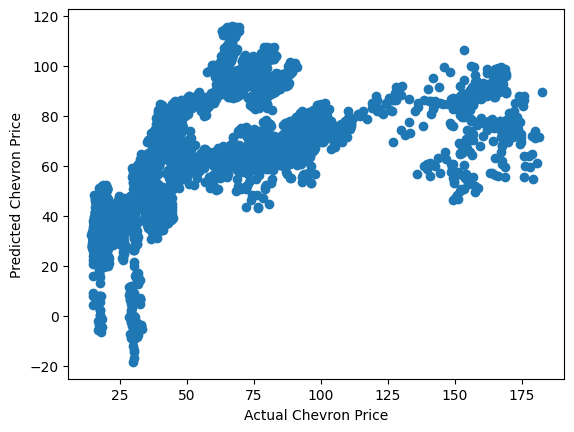

In [54]:
# Compare Chevron Actual Price to the Predicted One (trained data)

# As long as price goes up, prediction becomes sparse

plt.scatter(y_train, y_pred_train)
plt.xlabel('Actual Chevron Price')
plt.ylabel('Predicted Chevron Price')
plt.show()

In [55]:
# Finally, the R2 statistic does the same as Correlation matrix: both test the linear relashionshop between
# y (chevron price) and x (crude oil and natural gas)

# This means that crude oil and natural gas can "explain" almost 38% of chevron´s price.
# But look: Natural gas is inversely correlated.
# The purpose of this work is trying to explain a multiple linear relashionship.
# If we remove natural gas feature, I supose R2 will increase.

r2_score(y_train, y_pred_train)

0.37632950230556994

In [56]:
# Compare Chevron Actual Price to the Predicted One (Using tested data that has never been trained before)

y_pred_test = model.predict(X_test)

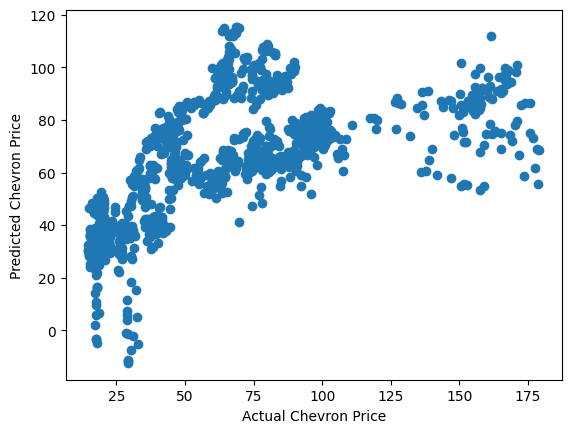

In [57]:
plt.scatter(y_test, y_pred_test)
plt.xlabel('Actual Chevron Price')
plt.ylabel('Predicted Chevron Price')
plt.show()

In [58]:
# When we use tested data, R2 score increases a little bit

r2_score(y_test, y_pred_test)

0.3966279561495969

# 6) Conclusion

In [59]:
df = pd.DataFrame()
#df.set_index(price.columns)
df['Chevron'] = price.columns[0]
df['Crude Oil'] = price.columns[1]
df['Natural Gas'] = price.columns[2]
index_labels=['Shape', 'Skewness', 'Adj Fisher Pearson Skew', 'Skew Test','Skew Test pvalue', 'ZScore', 'Kurtosis',
              'Kurtosis Test', 'Kurtosis Test pvalue', 'Corr Chev','Corr C_Oil','Corr N_Gas',
              'Levene Test Mean', 'Levene Test Mean pvalue', 'Levene Test Median', 'Levene Test Median pvalue']
df = pd.DataFrame(df,index=index_labels)
df.xs('Shape')['Chevron'] = 'Multimodal'
df.xs('Shape')['Crude Oil'] = 'Multimodal'
df.xs('Shape')['Natural Gas'] = 'Unimodal'
df.xs('Skewness')['Chevron'] = round(chevron_pearson_skew,3)
df.xs('Skewness')['Crude Oil'] =  round(crude_pearson_skew,3)
df.xs('Skewness')['Natural Gas'] =  round(gas_pearson_skew,3)
df.xs('Adj Fisher Pearson Skew')['Crude Oil'] = round(chevron_fispearson_skew,3)
df.xs('Adj Fisher Pearson Skew')['Chevron'] = round(crude_fispearson_skew,3)
df.xs('Adj Fisher Pearson Skew')['Natural Gas'] = round(gas_fispearson_skew,3)
df.xs('Skew Test')['Chevron'] = round(chevron_skewtest[0],2)
df.xs('Skew Test')['Crude Oil'] = round(crude_skewtest[0],2)
df.xs('Skew Test')['Natural Gas'] = round(gas_skewtest[0],2)
df.xs('Skew Test pvalue')['Chevron'] = '{:.7f}'.format(chevron_skewtest[1])
df.xs('Skew Test pvalue')['Crude Oil'] = '{:.7f}'.format(crude_skewtest[1])
df.xs('Skew Test pvalue')['Natural Gas'] = '{:.7f}'.format(gas_skewtest[1])
df.xs('ZScore')['Chevron'] = round(chevron_zscore,3)
df.xs('ZScore')['Crude Oil'] = round(crude_zscore,3)
df.xs('ZScore')['Natural Gas'] = round(gas_zscore,3)
df.xs('Kurtosis')['Chevron'] = round(chevron_kurt,3)
df.xs('Kurtosis')['Crude Oil'] = round(crude_kurt,3)
df.xs('Kurtosis')['Natural Gas'] = round(gas_kurt,3)
df.xs('Kurtosis Test')['Chevron'] = round(chevron_kurtest[0],2)
df.xs('Kurtosis Test')['Crude Oil'] = round(crude_kurtest[0],2)
df.xs('Kurtosis Test')['Natural Gas'] = round(gas_kurtest[0],2)
df.xs('Kurtosis Test pvalue')['Chevron'] = '{:.7f}'.format(chevron_kurtest[1])
df.xs('Kurtosis Test pvalue')['Crude Oil'] = '{:.7f}'.format(crude_kurtest[1])
df.xs('Kurtosis Test pvalue')['Natural Gas'] = '{:.7f}'.format(gas_kurtest[1])
df.xs('Corr Chev')['Chevron'] = round(corr.iloc[0,0],2)
df.xs('Corr Chev')['Crude Oil'] = round(corr.iloc[0,1],2)
df.xs('Corr Chev')['Natural Gas'] = round(corr.iloc[0,2],2)
df.xs('Corr C_Oil')['Chevron'] = round(corr.iloc[0,1],2)
df.xs('Corr C_Oil')['Crude Oil'] = round(corr.iloc[1,1],2)
df.xs('Corr C_Oil')['Natural Gas'] = round(corr.iloc[1,2],2)
df.xs('Corr N_Gas')['Chevron'] = round(corr.iloc[2,0],2)
df.xs('Corr N_Gas')['Crude Oil'] = round(corr.iloc[2,1],2)
df.xs('Corr N_Gas')['Natural Gas'] = round(corr.iloc[2,2],2)
df.xs('Levene Test Mean')['Chevron'] = round(levenetest_mean[0],2)
df.xs('Levene Test Mean pvalue')['Chevron'] = '{:.7f}'.format(levenetest_mean[1])
df.xs('Levene Test Median')['Chevron'] = round(levenetest_median[0],2)
df.xs('Levene Test Median pvalue')['Chevron'] = '{:.7f}'.format(levenetest_median[1])
df

,Chevron,Crude Oil,Natural Gas
Shape,Multimodal,Multimodal,Unimodal
Skewness,0.026,0.088,0.287
Adj Fisher Pearson Skew,0.254,0.887,1.442
Skew Test,23.98,7.81,33.99
Skew Test pvalue,0.0000000,0.0000000,0.0000000
ZScore,-1.569,-2.322,0.211
Kurtosis,0.576,-0.701,2.456
Kurtosis Test,7.1,-17.53,18.44
Kurtosis Test pvalue,0.0000000,0.0000000,0.0000000
Corr Chev,1.0,0.45,-0.31


Curiously, even when the Levene tests (of mean and median) indicate the heteroskedasticity (relevant difference in feature´s variances) between the three features, all the pvalues indicate we should reject null hipotesis and then, indicate the correlation between these features.

If we take away natural gas feature, we suppose correlation will be higher.